<a href="https://colab.research.google.com/github/MustafaBozkurt84/predictive-maintanance-LSTM/blob/master/Arima1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install pmdarima
!pip uninstall numpy
!pip install numpy

Uninstalling numpy-1.19.5:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.7
    /usr/local/lib/python3.7/dist-packages/numpy-1.19.5.dist-info/*
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libgfortran-2e0d59d6.so.5.0.0
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libopenblasp-r0-09e95953.3.13.so
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libquadmath-2d0c479f.so.0.0.0
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libz-eb09ad1d.so.1.2.3
    /usr/local/lib/python3.7/dist-packages/numpy/*
Proceed (y/n)? y
  Successfully uninstalled numpy-1.19.5
  Using cached https://files.pythonhosted.org/packages/73/ef/8967d406f3f85018ceb5efab50431e901683188f1741ceb053efcab26c87/numpy-1.20.2-cp37-cp37m-manylinux2010_x86_64.whl
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
ERROR: pmdarima 1.8.2 has requirement numpy~=1.19.0, but you'll have numpy 1.20.2 which is inco

In [68]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
df = pd.read_excel("/content/drive/MyDrive/Datasets/predictive maintance /AnalizDataPM.xlsx",engine='openpyxl')
df["Time"]= [str(i).replace("2020-02-02","2/2/2020").replace("2020-01-02","2/1/2020") for i in df["Time"]]


In [71]:
df['Time'] = pd.to_datetime(df['Time']) 
df['Time']=[str(i).split(":")[0] for i in df["Time"]]

In [72]:
df['Time'] = pd.to_datetime(df['Time'],format="%Y-%m-%d %H") #%Y-%m-%d %H:%M:%S

In [73]:
df=df.groupby("Time").mean()
df.reset_index(inplace=True)
df.to_csv("/content/drive/MyDrive/Datasets/predictive maintance /DataAnaliz.csv")
df.head()

,Time,vibx,vibz,temp,zacc,crest,zfreq
0,2020-01-17 00:00:00,1.208404,0.968665,29.501891,0.260534,3.817392,0.070044
1,2020-01-17 01:00:00,1.173835,1.045636,29.352279,0.262390,3.857893,0.069983
2,2020-01-17 02:00:00,1.161203,0.959516,29.187751,0.259026,3.811876,0.069978
3,2020-01-17 03:00:00,1.191830,0.957197,29.630256,0.260562,3.833699,0.070006
4,2020-01-17 04:00:00,1.027394,0.860651,30.167650,0.231498,4.164031,0.060902


In [74]:
for col in df.columns[1:]:
  df[col]=[round(i,2)for i in df[col]]

In [75]:
df1=df.copy()

In [76]:
df1['Time'] = [str(i).split()[0] for i in df1['Time']]
df1['Time'] = pd.to_datetime(df1['Time'],format="%Y-%m-%d")
df1.set_index("Time",inplace=True)



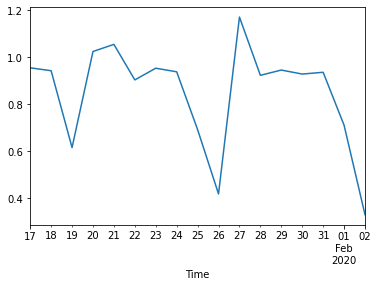

In [77]:
df1=df1.groupby("Time").mean()
df1.iloc[:,1].plot()

In [78]:
#df=pd.read_csv("/content/drive/MyDrive/Datasets/predictive maintance /DataAnaliz.csv",parse_date=True)
#df=df.iloc[:,1:]


# ARIMA and Seasonal ARIMA


## Autoregressive Integrated Moving Averages

The general process for ARIMA models is the following:
* Visualize the Time Series Data
* Make the time series data stationary
* Plot the Correlation and AutoCorrelation Charts
* Construct the ARIMA Model or Seasonal ARIMA based on the data
* Use the model to make predictions

Let's go through these steps!

In [79]:
df_vibx = df.loc[:,["Time","vibx"]]
df_vibz = df.loc[:,["Time","vibz"]]
df_temp = df.loc[:,["Time","temp"]]
df_zacc = df.loc[:,["Time","zacc"]]
df_crest = df.loc[:,["Time","crest"]]
df_zfreq = df.loc[:,["Time","zfreq"]]

In [80]:
dataframes=[df_vibx,df_vibz,df_temp,df_zacc,df_crest,df_zfreq]

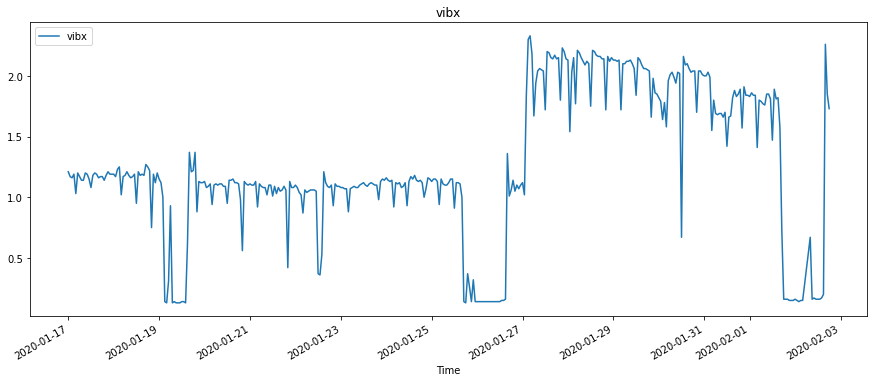

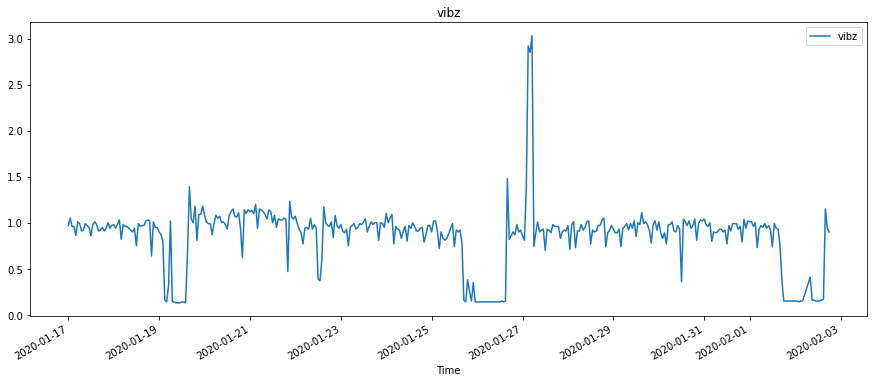

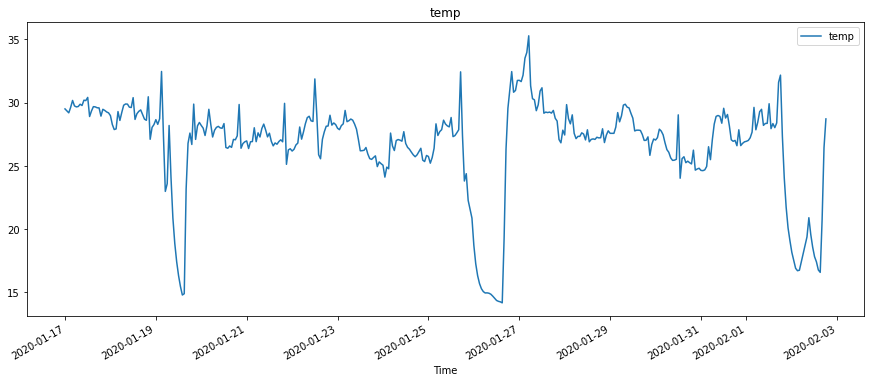

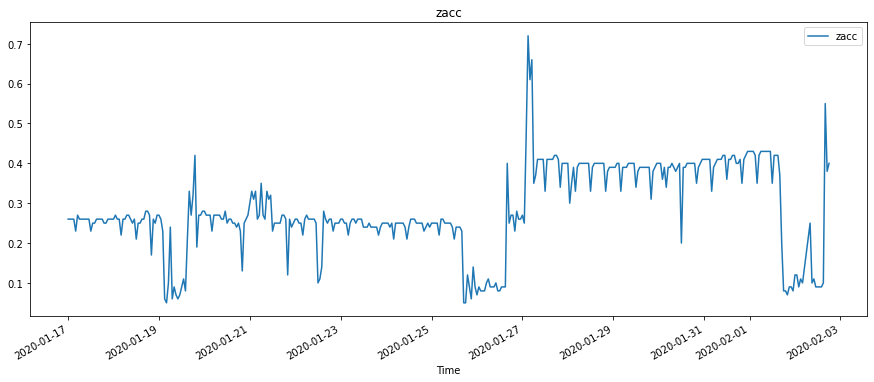

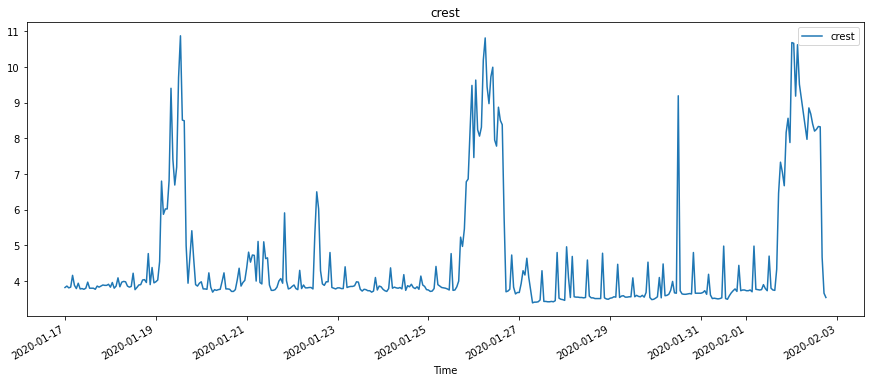

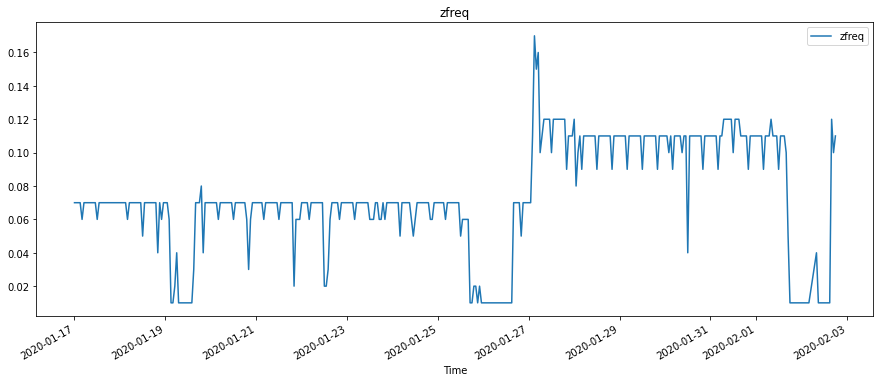

In [81]:
for data in dataframes:
    data.set_index("Time",inplace=True)
    data.index = pd.DatetimeIndex(data.index)
    data.plot(figsize=(15, 6))
    plt.title(data.columns[0])

In [82]:
df.describe()

,vibx,vibz,temp,zacc,crest,zfreq
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,1.261375,0.859200,26.667650,0.282550,4.515125,0.073850
std,0.603001,0.342819,3.785501,0.108411,1.651814,0.033036
min,0.130000,0.130000,14.170000,0.050000,3.390000,0.010000
25%,1.060000,0.847500,26.197500,0.240000,3.717500,0.060000
50%,1.140000,0.940000,27.495000,0.260000,3.825000,0.070000
75%,1.820000,1.000000,28.737500,0.390000,4.337500,0.110000
max,2.330000,3.030000,35.280000,0.720000,10.870000,0.170000


In [83]:
from statsmodels.tsa.stattools import adfuller

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(col,colname):
    print("-"*20 + f"{colname}"+ 20*"-")
    result=adfuller(col)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    print(20*"*")


In [84]:
for col in df.columns[1:]:
  adfuller_test(df.loc[:,col],col)

--------------------vibx--------------------
ADF Test Statistic : -3.0551679126069997
p-value : 0.030053820976266885
#Lags Used : 16
Number of Observations Used : 383
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
********************
--------------------vibz--------------------
ADF Test Statistic : -4.542673716917102
p-value : 0.0001645247111729759
#Lags Used : 16
Number of Observations Used : 383
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
********************
--------------------temp--------------------
ADF Test Statistic : -4.642235380620844
p-value : 0.00010789351563621728
#Lags Used : 17
Number of Observations Used : 382
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
********************
--------------------zacc--------------------
ADF Test Statistic : -3.271908460061478

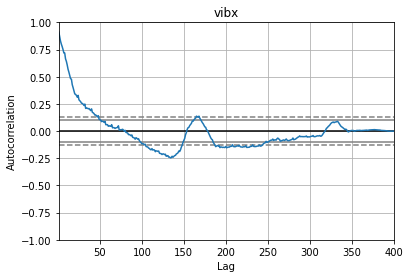

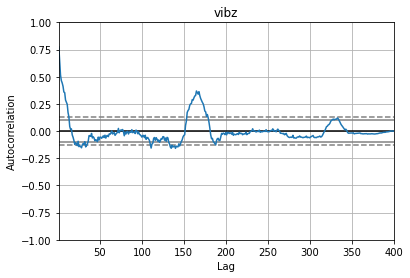

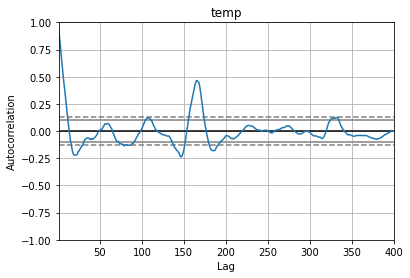

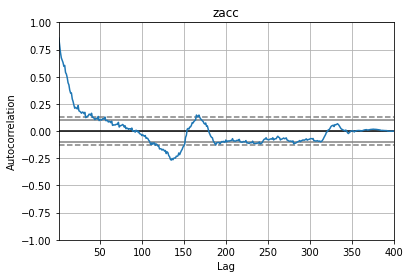

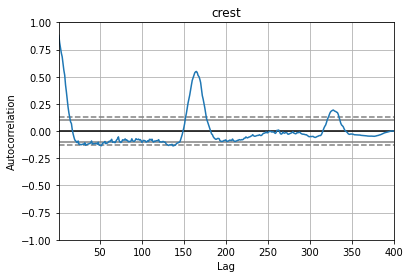

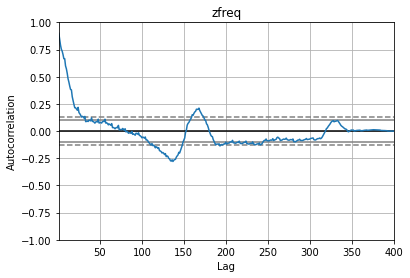

In [85]:
from pandas.plotting import autocorrelation_plot
for col in df.columns[1:]:
  autocorrelation_plot(df[col])
  plt.title(f"{col}")
  plt.show()

### Final Thoughts on Autocorrelation and Partial Autocorrelation

* Identification of an AR model is often best done with the PACF.
    * For an AR model, the theoretical PACF “shuts off” past the order of the model.  The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point.  Put another way, the number of non-zero partial autocorrelations gives the order of the AR model.  By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
    
    
* Identification of an MA model is often best done with the ACF rather than the PACF.
    * For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner.  A clearer pattern for an MA model is in the ACF.  The ACF will have non-zero autocorrelations only at lags involved in the model.
    
    p,d,q
    p AR model lags
    d differencing
    q MA lags

In [86]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
def Autocorrelation_plot(df,col):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(df[col],lags=40,ax=ax1)
    ax2 = fig.add_subplot(212)
    ax1.set_title(f" Autocorrelation ({col}) ")
    fig = plot_pacf(df[col],lags=40,ax=ax2)
    ax2.set_title(f" Partial Autocorrelation ({col})")
    

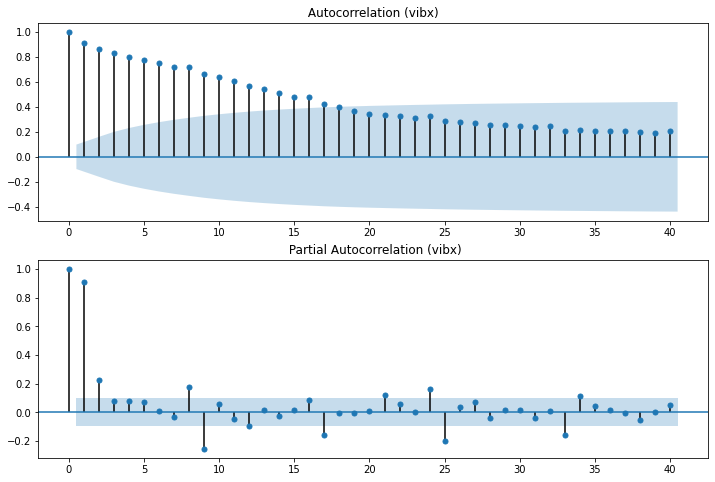

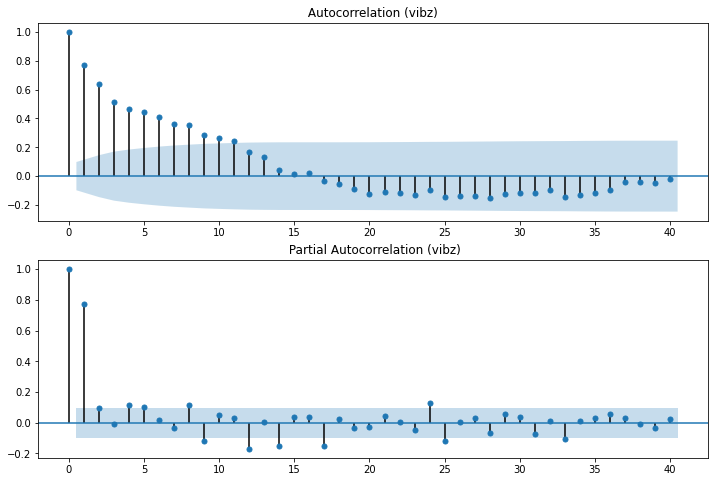

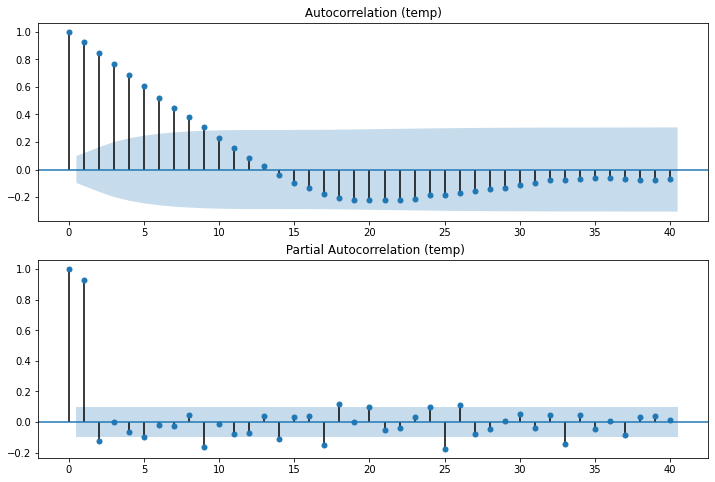

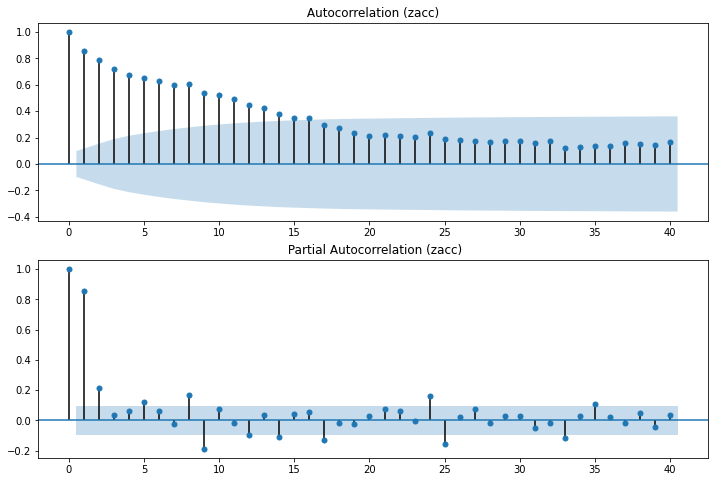

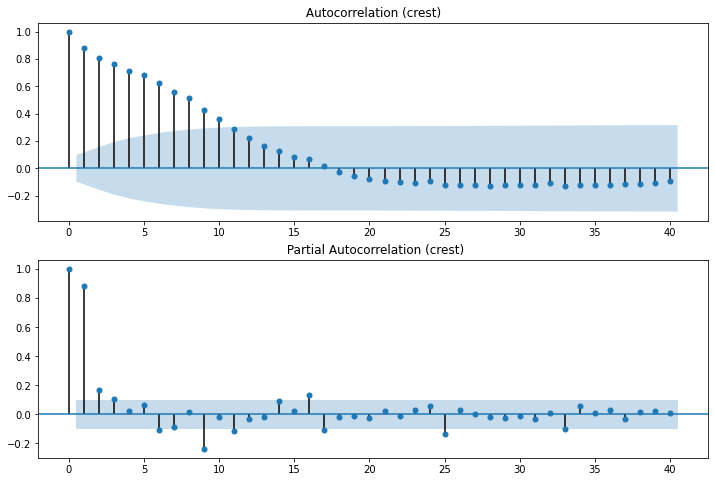

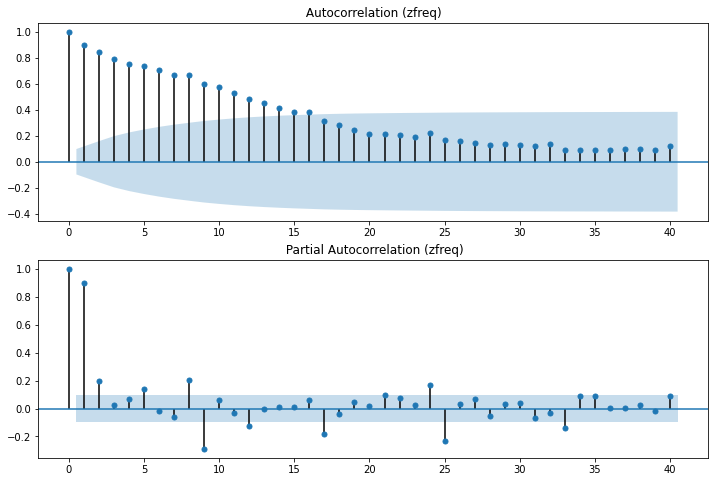

In [87]:
for col in df.columns[1:]:
  Autocorrelation_plot(df,col)

In [88]:

from pmdarima import auto_arima


In [89]:

for i in df1.columns:
    print(50*"*")
    print(i)
    stepwise_fit = auto_arima(df1[i], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

**************************************************
vibx
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=26.881, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=29.250, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=24.713, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=26.627, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=60.364, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=25.813, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=26.100, Time=0.31 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=26.245, Time=0.30 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=25.532, Time=0.07 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=28.063, Time=0.47 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=31.056, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=25.831, Time=0.11 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=26.007, Time=0.13 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=26.328, Time=0.07 sec
 ARIM

In [90]:
 def pickle_all(key,value):
         pickle_out = open("/content/drive/MyDrive/model_predictive_maintanence/"+key+"_arima.pkl", "wb")
         pickle.dump(value, pickle_out)
         pickle_out.close()

In [91]:
# For non-seasonal data
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
import statsmodels.api as sm

In [92]:
df=df.set_index("Time")

In [93]:
def arima_model(df,col,date,p,d,q,p1,d1,q1,m):
    df.index = pd.DatetimeIndex(df.index)
    df["arıza"]=df[col]
    df["arıza"]=np.where((df.index >"2020-01-27 14:00:00")&(df.index <"2020-01-27 16:00:00"),df[col].max(),df[col].min())
    #model=ARIMA(df[df.index < date][col],order=(p,d,q))
    model=sm.tsa.statespace.SARIMAX(df[df.index < date][col],order=(p, d, q),seasonal_order=(p1,d1,q1,m))
    model_fit=model.fit()
    
    pickle_all(col,model)
    model_fit.summary()
    df['forecast_'+col]=model_fit.predict(start=df.index[0],end=df.index[-1],typ='levels')
    df[[col,'forecast_'+col,"arıza"]].plot(figsize=(12,8))
    df["Dif"] = ((df[col]-df['forecast_'+col])/df[col])
    

In [94]:
for i in df.columns:
  print(f"{i} sensoru  {df[df[i]==df[i].max()].index[0]} de en yuksek degerı olan {df[i].max()} degerını kaydetmis ")


vibx sensoru  2020-01-27 04:00:00 de en yuksek degerı olan 2.33 degerını kaydetmis 
vibz sensoru  2020-01-27 05:00:00 de en yuksek degerı olan 3.03 degerını kaydetmis 
temp sensoru  2020-01-27 05:00:00 de en yuksek degerı olan 35.28 degerını kaydetmis 
zacc sensoru  2020-01-27 03:00:00 de en yuksek degerı olan 0.72 degerını kaydetmis 
crest sensoru  2020-01-19 13:00:00 de en yuksek degerı olan 10.87 degerını kaydetmis 
zfreq sensoru  2020-01-27 03:00:00 de en yuksek degerı olan 0.17 degerını kaydetmis 


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


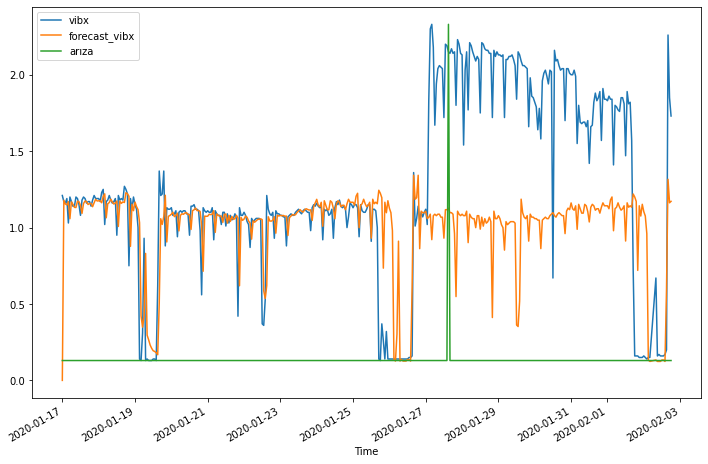

In [95]:
arima_model(df,"vibx","2020-01-24 00:00:00",2,0,1,1,0,0,7*24) 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


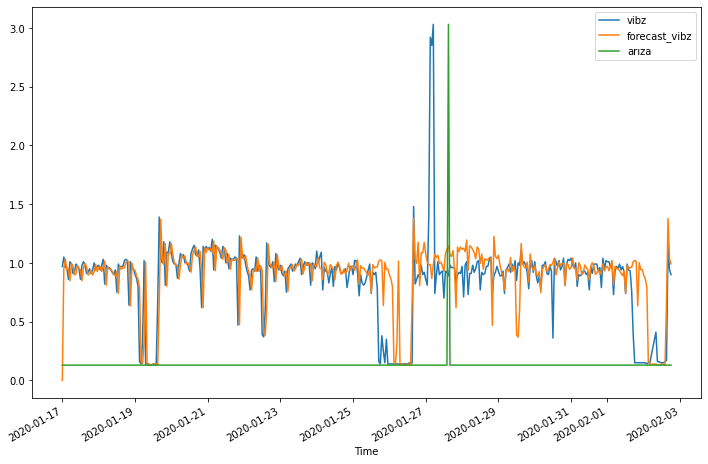

In [96]:
arima_model(df,"vibz","2020-01-24 00:00:00",1,0,0,1,0,0,24*7) 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


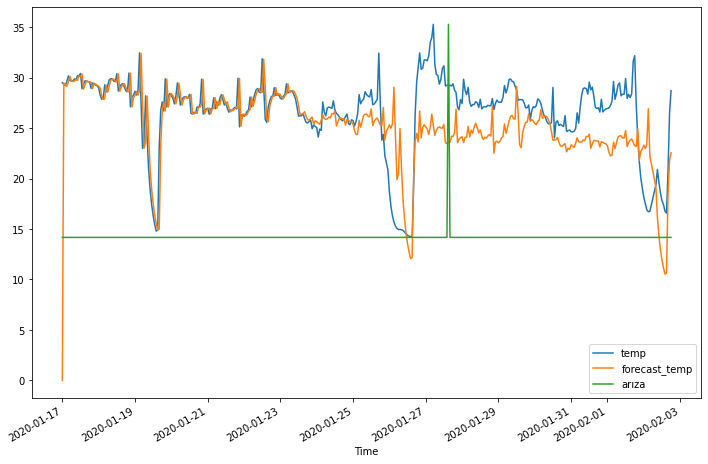

In [97]:
arima_model(df,"temp","2020-01-24 00:00:00",1,0,0,1,0,0,24*7) 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


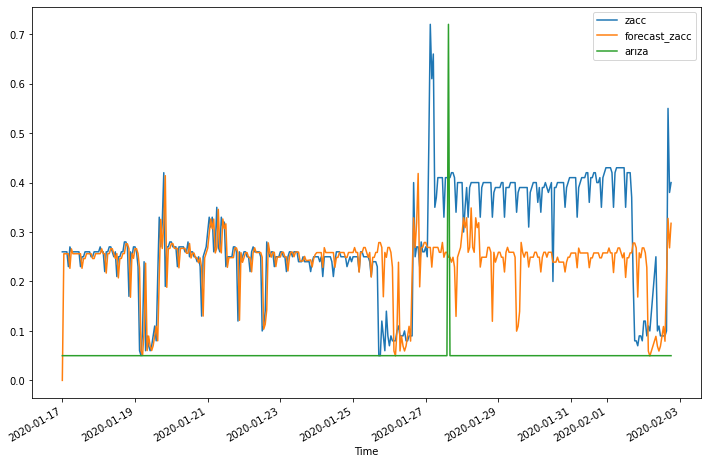

In [98]:

arima_model(df,"zacc","2020-01-24 00:00:00",1,0,0,1,0,0,24*7) 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


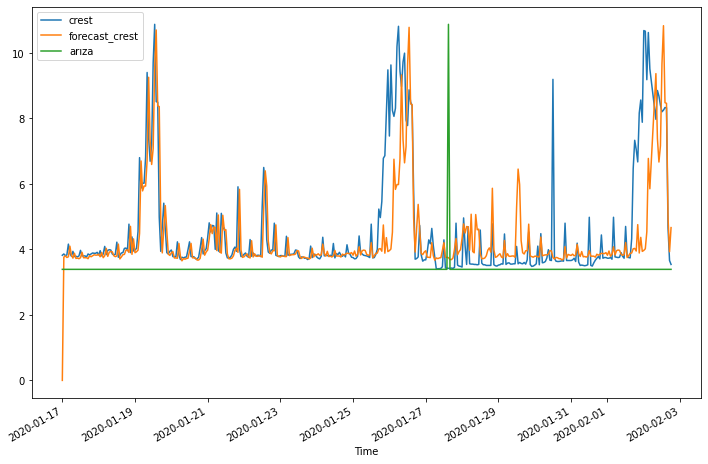

In [99]:
arima_model(df,"crest","2020-01-24 00:00:00",1,0,0,2,0,0,7*24)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


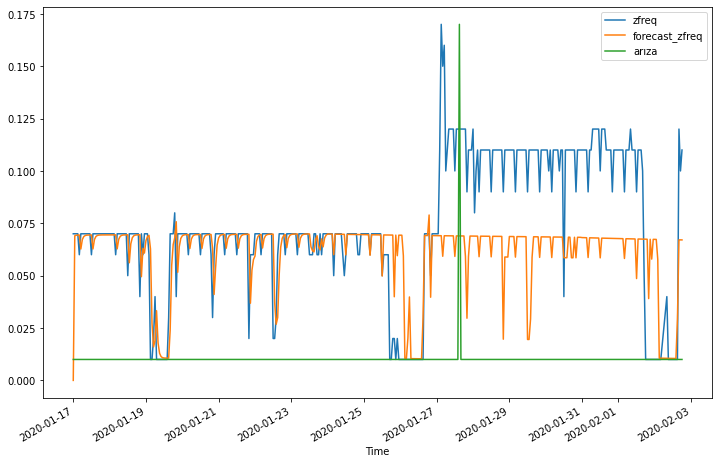

In [100]:
arima_model(df,"zfreq","2020-01-24 00:00:00",1,0,1,1,0,1,7*24) 

In [101]:
"""vibx sensoru  2020-01-27 04:00:00 de en yuksek degerı olan 2.3257780256553273 degerını kaydetmis 
vibz sensoru  2020-01-27 05:00:00 de en yuksek degerı olan 3.027547281323874 degerını kaydetmis 
temp sensoru  2020-01-27 05:00:00 de en yuksek degerı olan 35.27760047281316 degerını kaydetmis 
zacc sensoru  2020-01-27 03:00:00 de en yuksek degerı olan 0.7172621035058485 degerını kaydetmis 
crest sensoru  2020-01-19 13:00:00 de en yuksek degerı olan 10.865886603668711 degerını kaydetmis 
zfreq sensoru  2020-01-27 03:00:00 de en yuksek degerı olan 0.17328324986088234 degerını kaydetmis """

'vibx sensoru  2020-01-27 04:00:00 de en yuksek degerı olan 2.3257780256553273 degerını kaydetmis \nvibz sensoru  2020-01-27 05:00:00 de en yuksek degerı olan 3.027547281323874 degerını kaydetmis \ntemp sensoru  2020-01-27 05:00:00 de en yuksek degerı olan 35.27760047281316 degerını kaydetmis \nzacc sensoru  2020-01-27 03:00:00 de en yuksek degerı olan 0.7172621035058485 degerını kaydetmis \ncrest sensoru  2020-01-19 13:00:00 de en yuksek degerı olan 10.865886603668711 degerını kaydetmis \nzfreq sensoru  2020-01-27 03:00:00 de en yuksek degerı olan 0.17328324986088234 degerını kaydetmis '